In [1]:
import os
import glob 
import itertools
import random 

import requests

import numpy as np 
from  numba import jit

import scipy.stats as stats

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt

from tqdm import tqdm

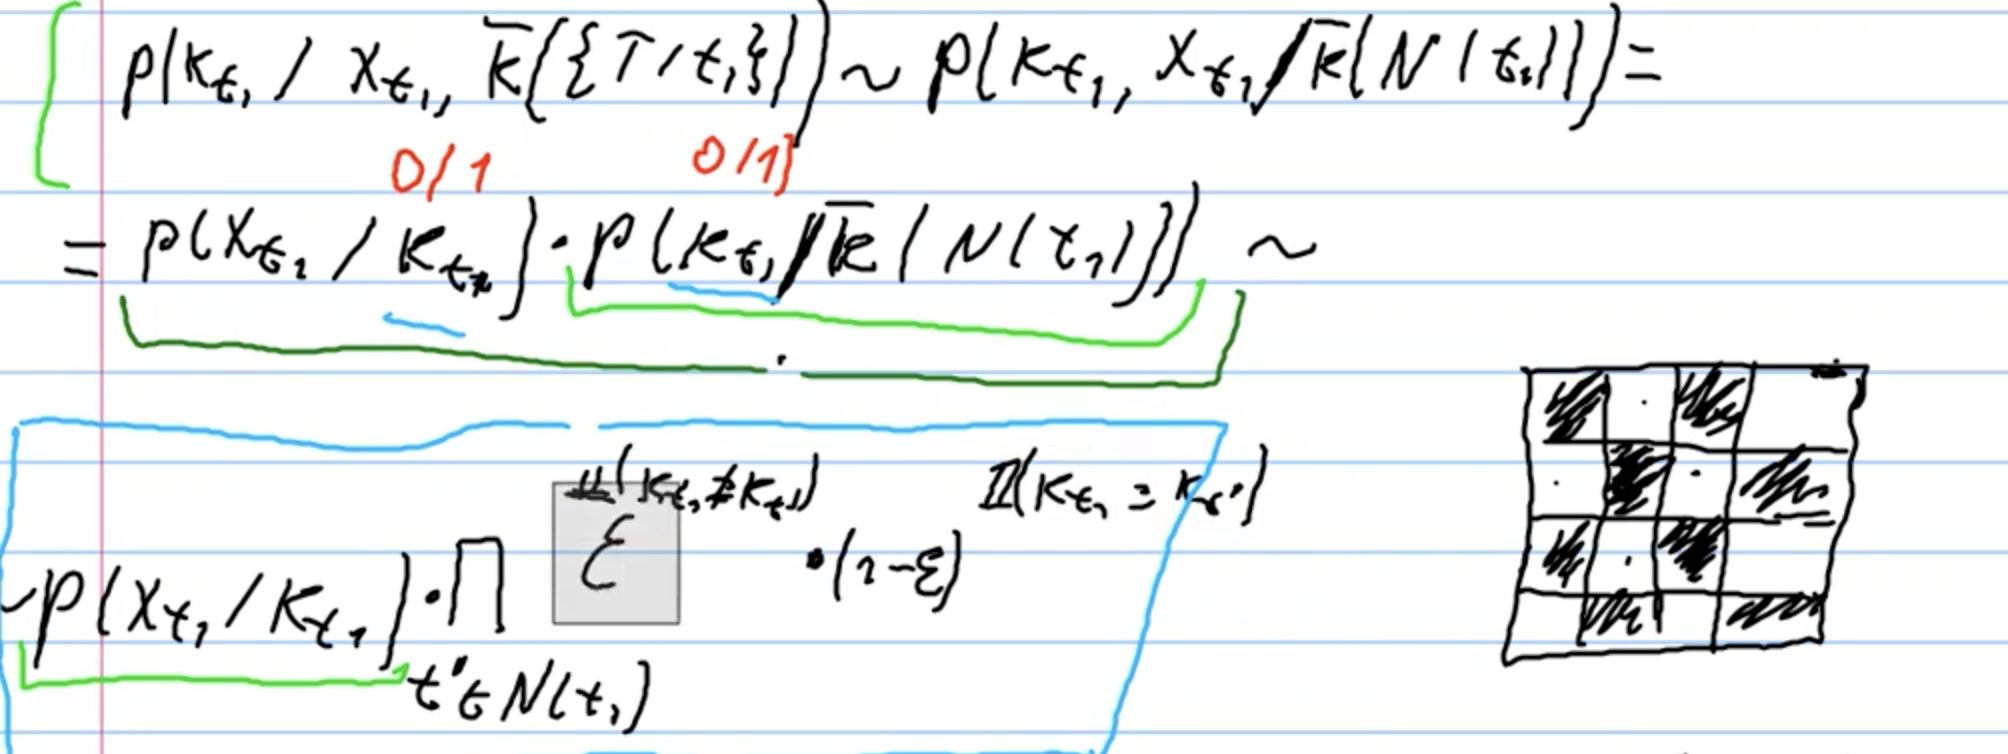

На основі двох сегментів картинки задати 3д Гаусовський розподіл
На 1 ітерації  згенерувати випадкову розмітку
На основі структури сусідства і розподілів обновити мітки
Обновити розподіли 
Повторити

На кожній ітерації використовувати старі мітки. У елементі н + 1 ітерації т мітка сусіда н + 1: н має мати значення ітерації т - 1

(533, 800, 3)


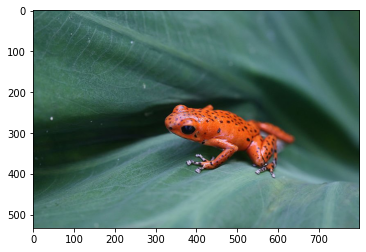

In [2]:
test_url = '''https://a-z-animals.com/media/animals/images/original/animal_classification6.jpg'''
image = np.array(Image.open(BytesIO(requests.get(test_url).content)))
plt.imshow(image)
print(image.shape)

[[ 6780.07024447 -2602.24708226 -1378.70148646]
 [-2602.24708226  6490.24313555 -2341.40594204]
 [-1378.70148646 -2341.40594204  4845.56420056]]
[125.3759375 111.2215625 100.5103125]


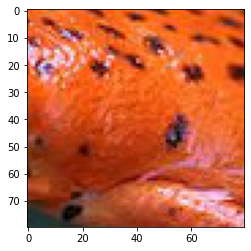

In [3]:
segment_0 = image[250:330, 400:480, :]
px_0 = segment_0.reshape(3, -1)
mu_0 = np.mean(px_0, axis = 1)
sigma_0 = np.cov(px_0)
print(sigma_0)
print(mu_0)
plt.imshow(segment_0)

[[647.42312522 219.16848234 353.42088767]
 [219.16848234 509.19275363  34.74977602]
 [353.42088767  34.74977602 960.07180756]]
[95.50312925 83.06180952 52.42685714]


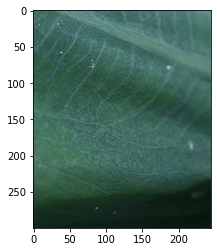

In [4]:
segment_1 = image[:300, 55:300, :]
px_1 = segment_1.reshape(3, -1)
mu_1 = np.mean(px_1, axis = 1)
sigma_1 = np.cov(px_1)
print(sigma_1)
print(mu_1)
plt.imshow(segment_1)

In [5]:
def make_dist(mu_0, mu_1, sigma_0, sigma_1):
    d_0 = stats.multivariate_normal(mean = mu_0, cov = sigma_0)
    d_1 = stats.multivariate_normal(mean = mu_1, cov = sigma_1)
    return d_0, d_1

@jit(nopython = True)
def get_neigb(_markup, x, y):
    out = []
    if x > 0:
        out.append(_markup[x-1, y])
    if y > 0:
        out.append(_markup[x, y-1])
    if y < _markup.shape[1] - 1:
        out.append(_markup[x, y+1])
    if x < _markup.shape[0] - 1:
        out.append(_markup[x+1, y])
    return np.array(out)


@jit(nopython = True)
def estimate_neigb(neigb, eps):
    """
    >>> estimate_neigb(neigb_ = [1, 1, 1, 1], eps = 0.001)
       array([1.00000000e-12, 9.96005996e-01])
    >>> neigb(neigb_ = [0, 0, 0, 0], eps = 0.001)
       array([9.96005996e-01, 1.00000000e-12])
    >>> neigb(neigb_ = [1, 1, 0, 0], eps = 0.001)  
       array([9.98001e-07, 9.98001e-07])
    """
    k_0 = np.array([1 if i == 0 else 0 for i in neigb])
    k_1 = np.array([1 if i == 1 else 0 for i in neigb])
    t_ = len(neigb)
    return np.array([eps**(t_ - np.sum(k_0)) * (1 - eps)**np.sum(k_0),
                     eps**(t_ - np.sum(k_1)) * (1 - eps)**np.sum(k_1)])


@jit(nopython = True)
def make_mark(neigb, density_0, density_1):
    k = np.array([density_0 * neigb[0],
         density_1 * neigb[1]])
    normalization = np.sum(k)
    return k/normalization


@jit(nopython = True)
def gibbs_sampler(image, p_k, _markup, pixel_indices, eps):
    shape_0, shape_1 = image.shape[0], image.shape[1]
    estimated_markup_ = np.zeros((shape_0, shape_1), dtype = np.float32)
    p_k_ = np.zeros((shape_0, shape_1, 2), dtype = np.float32)    
    for (i, j) in pixel_indices:
        neigb = estimate_neigb(get_neigb(_markup, i, j), eps)
        k = make_mark(neigb, p_k[i, j, 0], p_k[i, j, 1])
        estimated_markup_[i, j] = 0 if k[0] > k[1] else 1
        p_k_[i, j, 0] = k[0]
        p_k_[i, j, 1] = k[1]
    return  p_k_, estimated_markup_

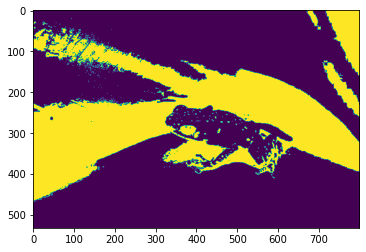

In [6]:
px_0, mu_0, sigma_0  = segment_0.reshape(3, -1), np.mean(px_0, axis = 1), np.cov(px_0)
px_1, mu_1, sigma_1 = segment_1.reshape(3, -1), np.mean(px_1, axis = 1), np.cov(px_1)
d_0, d_1 = make_dist(mu_0, mu_1, sigma_0, sigma_1)
shape_0, shape_1 = image.shape[0], image.shape[1]

# _markup = (np.random.random((shape_0, shape_1)) > .5).astype(int)

pixel_indices = np.array(list(itertools.product(range(shape_0), range(shape_1))))
def_markup = lambda x, y: 0 if d_0.pdf(image[x, y]) > d_1.pdf(image[x,y]) else 1 
_markup = np.array([def_markup(x, y) for x, y in pixel_indices]).reshape(shape_0, shape_1)
p_k = np.array([[d_0.pdf(image[x, y]), d_1.pdf(image[x, y])] for x, y in pixel_indices]).reshape(shape_0, shape_1, 2)
plt.imshow(_markup)

In [7]:
def main(image, p_k, _markup, pixel_indices, epoch, eps):
    temp  = []
    for iteration in range(epoch):
        p_k, _markup = gibbs_sampler(image, p_k, _markup, pixel_indices, eps)
        if iteration % 20 == 0:
            temp.append(_markup)
    return temp, _markup

In [8]:
temp, final_markup = main(image, p_k, _markup, pixel_indices, 50, 0.31)

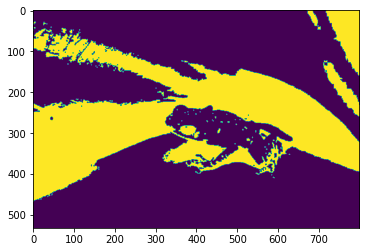

In [9]:
plt.imshow(final_markup)